# **Extract data through Google API**

In [94]:
from call_ListGauges import get_ListGauges
from call_GetGaugeModel import get_GetGaugeModel
from call_QueryGaugeForecasts import get_QueryGaugeForecasts
from plots import get_custom_palette
from plots import set_plot_style
from plots import map_gauge_coordinates_of_country
from plots import plot_danger_levels_hist
from plots import plot_gauge_forecast_for_issue_time
from plots import plot_week_of_gauge_forecast_for_issue_time

In [95]:
import os
from typing import List, Dict, Any
import json
import pandas as pd
import geopandas as gpd
from shapely import geometry
import requests
import pprint
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# Delete dependencies later, keep them for now for experminetation

**Use the API Yes/No**

In [96]:
QUERY = bool(0)

### **Goal:**

Make main() that takes as argument a country and generates a few .csv files with all data for all gauges in that country


##### **Steps**:
To get the data from the Google Bucket into workable format, we follow:
* Connect with the API
* **Expand this step!** Set-up pipeline which downloads all relevant data per country code
* Format the data into DateTime (y) and features (x)
* Store externally as .csv

##### **Background info -- API**
The API has three basic functions:
* *ListGauges*: Returns a list of supported gauges within a given country (code)
* *GetGaugeModel*: Returns model information of a specific gauge (within a given country, that is)
* *QueryGaugeForecasts*: Returns the forecasts of specific gauge

We'll create a pipeline going through these three functions, taking as input just the target country and outputting a DateTime-indexed .csv with all available forecasts for that country's available gauges. 

##### **(??? -> Maybe this is too much... A format which uses a list of matrices (an implicit tensor) where the matrices are just one gauge might be better. Either way, the metadata is best stored separately in a separate .csv. Choose adequate naming here.)**

For subsequent analysis, see ../analyse_data/

In [97]:
# Note: add this folder manually at the pointed path for the script to run
# For the key, ask the owner of the repository or try guessing
path_API_key = "../../data/keys/API_key.txt"

#### **Executing ListGauges command**

In [98]:
if QUERY:
    df_gauges_ML = get_ListGauges('Mali', path_API_key)
    df_gauges_ML.to_csv(
        "../../data/processed/metadata/metadata_gauges_Mali.csv",
        index = False,
        decimal = '.',
        sep = ';',
        encoding = 'utf-8'
    )
else:
    df_gauges_ML = pd.read_csv(
        "../../data/processed/metadata/metadata_gauges_Mali.csv",
        sep = ';',
        decimal = '.',
        encoding = 'utf-8'
    )

In [99]:
print(type(df_gauges_ML))
print(len(df_gauges_ML))
print(df_gauges_ML.columns)

<class 'pandas.core.frame.DataFrame'>
16
Index(['siteName', 'source', 'river', 'gaugeId', 'qualityVerified', 'latitude',
       'longitude'],
      dtype='object')


In [100]:
print(df_gauges_ML.head(2))

   siteName source river           gaugeId  qualityVerified   latitude  \
0       NaN  HYBAS   NaN  hybas_1120661040             True  13.985417   
1       NaN  HYBAS   NaN  hybas_1120739110             True  11.977083   

   longitude  
0  -7.152083  
1  -6.360417  


In [101]:
def get_country_gauge_coords(df_gauges: pd.DataFrame) -> pd.DataFrame:
    """
    Return the DataFrame with gauge names and coordinates of a specific country

    :param df_gauges: DataFrame with gauge information
    :param country_name: Name of the country
    :return: DataFrame with gauge names and coordinates of a specific country
    """
    return df_gauges.set_index('gaugeId')[['latitude', 'longitude']]


def export_country_gauge_coords(
        df_gauges: pd.DataFrame, out: bool = False, country_name: str = None) -> None:
    """
    Export gauge names and coordinates of a specific country to .csv.
    Optionally prints them as well (default = False)

    :param df_gauges: DataFrame with gauge information
    :param country_name: Name of the country
    """
    df_subset = get_country_gauge_coords(df_gauges)
    df_subset.to_csv(f"../../data/processed/gauge_coords/coords_gauges_{country_name}.csv",
                     index = True,
                     sep = ';',
                     decimal = '.',
                     encoding = 'utf-8')
    
    if out:
        print(f'Coordinates of gauges in {country_name}')
        print(df_subset)

In [102]:
export_country_gauge_coords(df_gauges_ML, True, 'Mali')

Coordinates of gauges in Mali
                   latitude  longitude
gaugeId                               
hybas_1120661040  13.985417  -7.152083
hybas_1120739110  11.977083  -6.360417
hybas_1120737100  12.018750  -8.322917
hybas_1120679780  13.493750  -6.202083
hybas_1121900350  13.685417  -5.893750
hybas_1121890140  14.314583  -4.422917
hybas_1120758950  11.427083  -6.581250
hybas_1120641660  14.506250  -4.206250
hybas_1121893090  14.131250  -5.039583
hybas_1120650110  14.277083  -6.927083
hybas_1121919510  12.410417  -8.106250
hybas_1120705070  12.835417  -7.581250
hybas_1120689830  13.210417  -7.077083
hybas_1121905290  13.360417  -6.789583
hybas_1121895840  13.956250  -5.360417
hybas_1120766460  11.222917  -8.485417


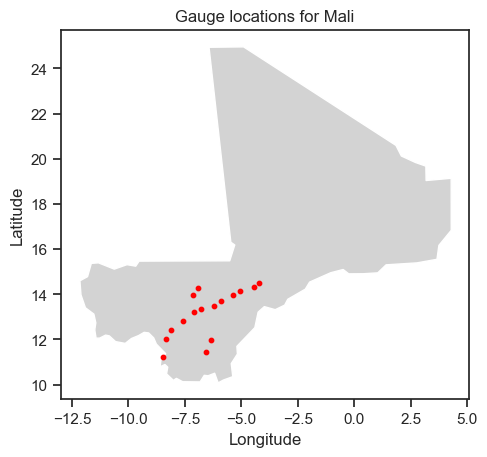

In [103]:
map_gauge_coordinates_of_country(df_gauges_ML, 'Mali')

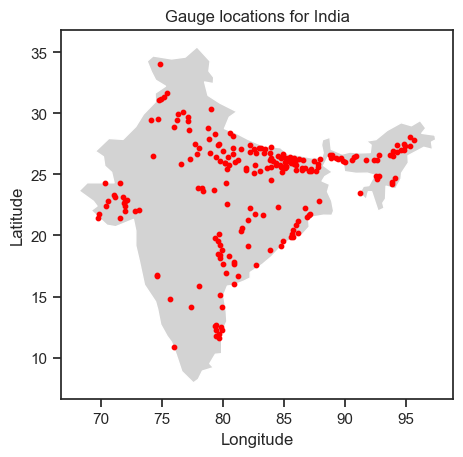

In [104]:
map_gauge_coordinates_of_country(
    get_ListGauges(
        'India', path_API_key
        ), 'India'
    )

#### **Executing GetGaugeModel command**

In [105]:
df_gauge_models_ML = 0

In [106]:
if QUERY:
    df_gauge_models_ML = get_GetGaugeModel(path_API_key, df_gauges_ML)
    df_gauge_models_ML.to_csv(
        f"../../data/processed/gauge_metadata_per_country/gauge_meta_Mali.csv",
        index = False,
        sep = ';',
        decimal = '.',
        encoding = 'utf-8'
    )  
else :
    df_gauge_models_ML = pd.read_csv(
        "../../data/processed/gauge_metadata_per_country/gauge_meta_Mali.csv",
        sep = ';',
        decimal = '.',
        encoding = 'utf-8'
    )

In [107]:
print(type(df_gauge_models_ML))
print(len(df_gauge_models_ML))
print(df_gauge_models_ML.head(2))

<class 'pandas.core.frame.DataFrame'>
16
            gaugeId           gaugeValueUnit  qualityVerified  dangerLevel  \
0  hybas_1120661040  CUBIC_METERS_PER_SECOND             True   100.935829   
1  hybas_1120650110  CUBIC_METERS_PER_SECOND             True   128.684509   

   extremeDangerLevel  warningLevel  
0          192.571655     52.250954  
1          251.501968     67.534431  


In [108]:
print(df_gauge_models_ML.columns)

Index(['gaugeId', 'gaugeValueUnit', 'qualityVerified', 'dangerLevel',
       'extremeDangerLevel', 'warningLevel'],
      dtype='object')


In [109]:
df_gauge_models_ML

,gaugeId,gaugeValueUnit,qualityVerified,dangerLevel,extremeDangerLevel,warningLevel
0,hybas_1120661040,CUBIC_METERS_PER_SECOND,True,100.935829,192.571655,52.250954
1,hybas_1120650110,CUBIC_METERS_PER_SECOND,True,128.684509,251.501968,67.534431
2,hybas_1120758950,CUBIC_METERS_PER_SECOND,True,729.448914,919.753723,554.390076
3,hybas_1120641660,CUBIC_METERS_PER_SECOND,True,2351.688477,2674.150391,2071.439697
4,hybas_1121890140,CUBIC_METERS_PER_SECOND,True,2447.351074,2765.175781,2164.199951
5,hybas_1120739110,CUBIC_METERS_PER_SECOND,True,852.963501,1097.714722,635.864990
6,hybas_1120679780,CUBIC_METERS_PER_SECOND,True,3779.932617,4213.734375,3336.140137
7,hybas_1121900350,CUBIC_METERS_PER_SECOND,True,3778.391846,4214.509277,3332.435791
8,hybas_1121895840,CUBIC_METERS_PER_SECOND,True,3752.041016,4179.999023,3312.148193
9,hybas_1121893090,CUBIC_METERS_PER_SECOND,True,2800.095459,3149.558838,2487.176758


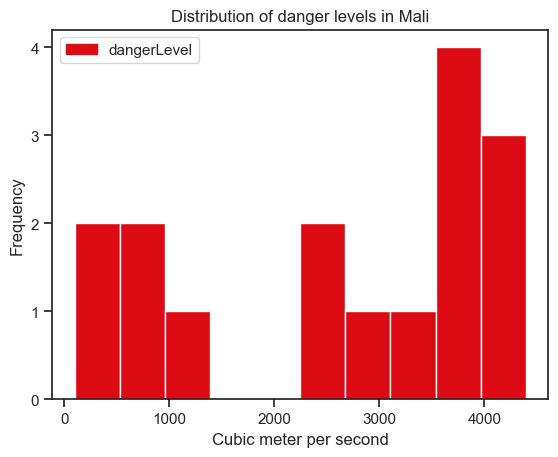

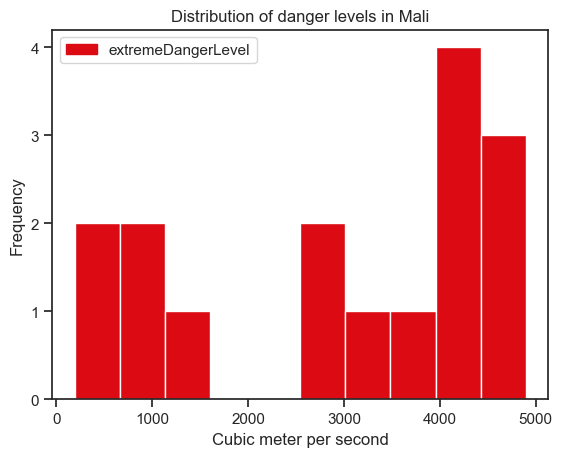

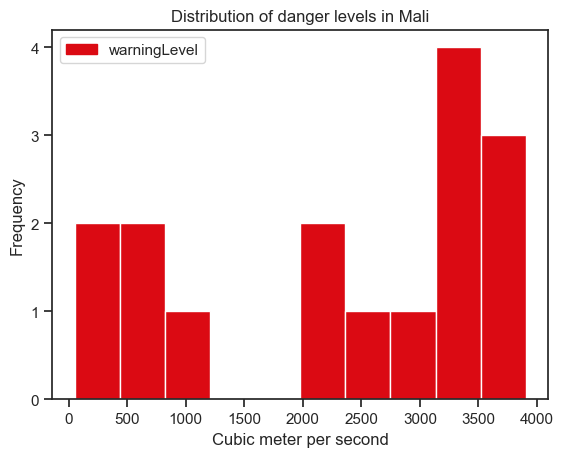

In [110]:
plot_danger_levels_hist(df_gauge_models_ML, 'Mali')

#### **Executing QueryGaugeForecast command**

In [111]:
last_week = datetime.datetime.now() - datetime.timedelta(days = 7)
tomorrow = datetime.datetime.now() + datetime.timedelta(days = 1)

print(last_week)
print(tomorrow)

df_gauges_ML['gaugeId'].tolist()[0]

print(type(last_week))
print(str(last_week)[:10])

2024-09-30 00:10:52.504865
2024-10-08 00:10:52.504865
<class 'datetime.datetime'>
2024-09-30


In [112]:
a = datetime.datetime.now() - datetime.timedelta(days = 91)
b = datetime.datetime.now() + datetime.timedelta(days = 1)
print(a.date(), b.date(), b.date() - a.date())

if QUERY:
    df_forecasts_ML = get_QueryGaugeForecasts(
        path_API_key, df_gauges_ML['gaugeId'].tolist(), (a, b)
    )
    df_forecasts_ML.to_csv(
        f"../../data/floods-data/mali/{str(a)[:10]}_to_{str(b)[:10]}.csv",
        sep = ';',
        decimal = '.',
        encoding = 'utf-8'
)

2024-07-08 2024-10-08 92 days, 0:00:00


In [113]:
df_forecasts_ML = pd.read_csv(
    "../../data/floods-data/mali/2024-07-08_to_2024-10-08.csv",
    index_col = 0,
    sep = ';',
    decimal = '.',
    encoding = 'utf-8'
)

In [114]:
print(df_forecasts_ML.columns)
print(len(df_forecasts_ML))
print(df_forecasts_ML.head(2))

Index(['gauge_ID', 'issue_date', 'issue_time', 'fc_date', 'fc_value'], dtype='object')
11776
           gauge_ID  issue_date                        issue_time     fc_date  \
0  hybas_1120641660  2024-07-08  2024-07-08 13:54:03.433896+00:00  2024-07-07   
1  hybas_1120641660  2024-07-08  2024-07-08 13:54:03.433896+00:00  2024-07-08   

     fc_value  
0  238.515350  
1  247.505783  


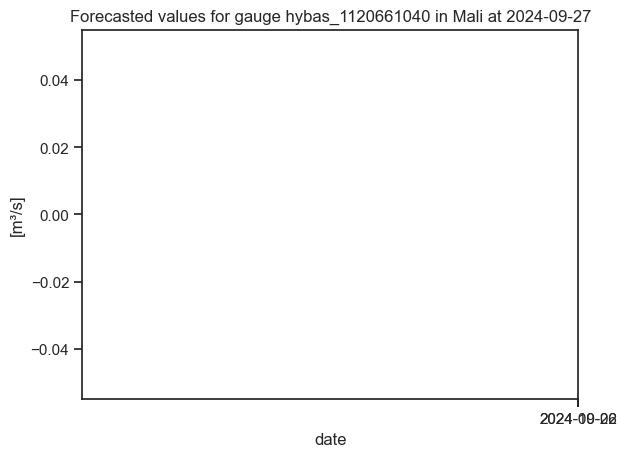

In [121]:
start_date = datetime.datetime.now() - datetime.timedelta(days = 10)

plot_gauge_forecast_for_issue_time(
    df_forecasts_ML, df_gauges_ML['gaugeId'].tolist()[0], start_date, 'Mali'
)

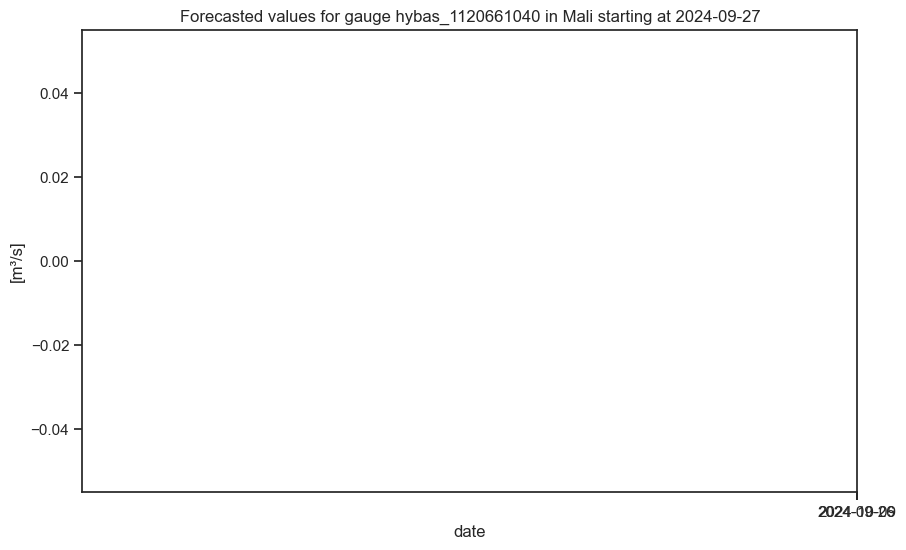

In [116]:
plot_week_of_gauge_forecast_for_issue_time(
    df_forecasts_ML, df_gauges_ML['gaugeId'].tolist()[0], start_date, 'Mali'
)

In [160]:
def create_dates_series(start_date : str, delta: int) -> pd.Series:
    """
    Create a series of dates starting from a given date and going on for a given number of days

    :param start_date: starting date
    :param delta: number of days
    :return: Series of dates
    """
    start_date = datetime.datetime(start_date, "%Y-%m-%d").date()
    return pd.Series(
        # minus one here because, strangely enough, the first forecasted
        # date is one day in the past compared to the issue date...
        [start_date + datetime.timedelta(days = idx - 1) for idx in range(0, delta)]
    )


def set_custom_date_ticks(ax: plt.Axes, dates: pd.Series) -> None:
    """
    Set custom date ticks on the x-axis of a plot, where only
    the first and final date are displayed, while keeping the ticks

    :param ax: Axes object
    :param date_series: Series of dates
    """
    print(dates)
    ax.set_xticks(dates)
    x_labels = [
        dates.iloc[0].strftime('%Y-%m-%d')] + \
        [''] * (len(dates) - 2) + \
        [dates.iloc[-1].strftime('%Y-%m-%d') \
    ]
    ax.set_xticklabels(x_labels)


def plot_gauge_forecast_for_issue_time(
        df : pd.DataFrame, gauge: str, issue_date : datetime.datetime, country : str = None) -> None:
    """
    Plots with a graph the forecasted values for a specific gauge and issue time

    :param df: DataFrame with forecasted values
    :param gauge: ID of the gauge
    :param issue_time: issue time of the forecast
    :param country: Name of the country
    """
    set_plot_style()
    df_subset = df[(df['gauge_ID'] == gauge) & (df['issue_date'] == str(issue_date.date()))]

    ax = sns.lineplot(
        x = 'fc_date',
        y = 'fc_value',
        data = df_subset,
        color = '#DB0A13'
    )

    # only display first and final forecast date on date-axis while keeping ticks
    # set_custom_date_ticks(
    #     ax,
    #     create_dates_series(issue_date.date(), 7)
    # )

    plt.title(f'Forecasted values for gauge {gauge} in {country} at {issue_date.date()}')
    plt.xlabel('date')
    plt.ylabel('[m³/s]')
    plt.show()

In [161]:
# print(df_forecasts_ML['issue_date'].apply(type))
# print(df_forecasts_ML['issue_time'].apply(type))
# print(df_forecasts_ML['fc_date'].apply(type))

2024-09-27 00:41:05.841057


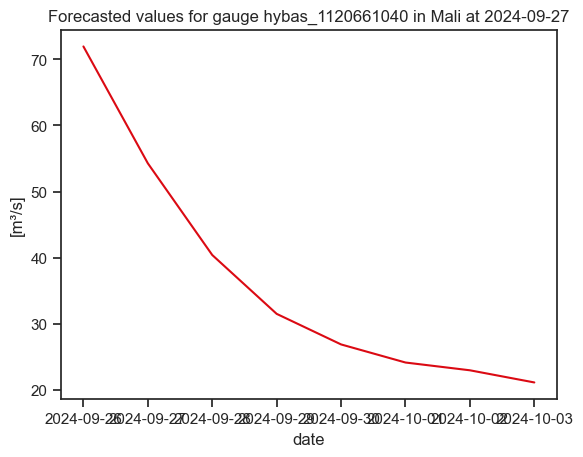

In [162]:
start_date = datetime.datetime.now() - datetime.timedelta(days = 10)
print(start_date)
plot_gauge_forecast_for_issue_time(
    df_forecasts_ML, df_gauges_ML['gaugeId'].tolist()[0], start_date, 'Mali'
)

In [165]:
def plot_week_of_gauge_forecast_for_issue_time(
        df : pd.DataFrame, gauge: str, issue_date : datetime.datetime, country : str = None) -> None:
    """
    Plots the forecasted values for a specific gauge over a week of
    issue times, giving seven graphs in total, each of (7 + 1 =) 8 days length 

    :param df: DataFrame with forecasted values
    :param gauge: ID of the gauge
    :param issue_time: first issue time
    :param country: Name of the country
    """
    set_plot_style()
    plt.figure(figsize = (10, 6))
    custom_palette = get_custom_palette(7)
    
    for idx in range(7):
        df_subset = df[
            (df['gauge_ID'] == gauge) &
            (df['issue_date'] == str((issue_date + datetime.timedelta(days = idx)).date()))]

        sns.lineplot(
        x = 'fc_date',
        y = 'fc_value',
        data = df_subset,
        color = custom_palette[idx]
    )

    # set_custom_date_ticks(
    #     plt.gca(),
    #     create_dates_series(issue_date.date(), 7 + 7)
    # )

    plt.title(f'Forecasted values for gauge {gauge} in {country} starting at {issue_date.date()}')
    plt.xlabel('date')
    plt.ylabel('[m³/s]')
    plt.show()

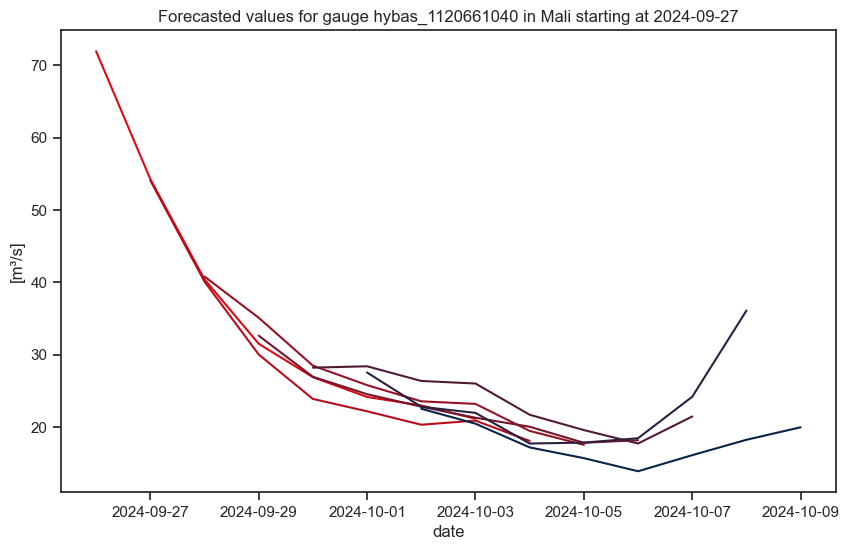

In [166]:
plot_week_of_gauge_forecast_for_issue_time(
    df_forecasts_ML, df_gauges_ML['gaugeId'].tolist()[0], start_date, 'Mali'
)

In [167]:
def plot_month_of_gauge_forecast_for_issue_time(
        df : pd.DataFrame, gauge: str, issue_date : datetime.datetime, country : str = None) -> None:
    """
    Plots the forecasted values for a specific gauge over a month of
    issue times, giving 30 graphs in total, each of (7 + 1 =) 8 days length 

    :param df: DataFrame with forecasted values
    :param gauge: ID of the gauge
    :param issue_time: first issue time
    :param country: Name of the country
    """
    set_plot_style()
    plt.figure(figsize = (10, 6))
    custom_palette = get_custom_palette(30)
    
    for idx in range(30):
        df_subset = df[
            (df['gauge_ID'] == gauge) &
            (df['issue_date'] == str((issue_date + datetime.timedelta(days = idx)).date()))]

        sns.lineplot(
        x = 'fc_date',
        y = 'fc_value',
        data = df_subset,
        color = custom_palette[idx]
    )

    # set_custom_date_ticks(
    #     plt.gca(),
    #     create_dates_series(issue_date.date(), 30 + 7)
    # )

    plt.title(f'Forecasted values for gauge {gauge} in {country} starting at {issue_date.date()}')
    plt.xlabel('date')
    plt.ylabel('[m³/s]')
    plt.show()

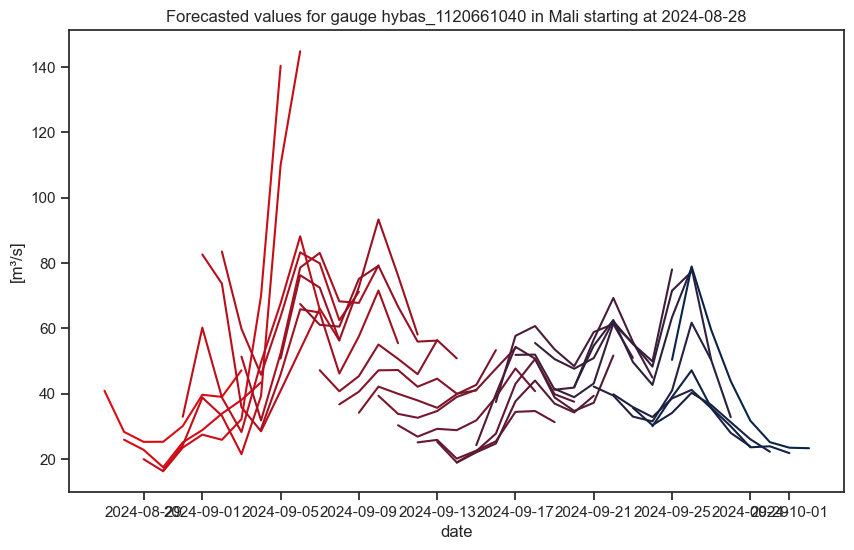

In [169]:
start_date = datetime.datetime.now() - datetime.timedelta(days = 40)

plot_month_of_gauge_forecast_for_issue_time(
    df_forecasts_ML, df_gauges_ML['gaugeId'].tolist()[0], start_date, 'Mali'
)